In [1]:
import numpy as np
import pandas as pd
import pyarrow
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
data_path = '../13. Data from R 50000/'
X_train = pd.read_parquet(data_path + 'X_train_2024.parquet', engine='pyarrow')
X_test = pd.read_parquet(data_path + 'X_test_2024.parquet', engine='pyarrow')
X_train_original_scale = pd.read_parquet(data_path + 'X_train_original_scale_2024.parquet', engine='pyarrow')
seed_num = 2024
# Load y_train and y_test
y_train = pd.read_parquet(data_path + 'y_train_2024.parquet').iloc[:, 0]
y_test = pd.read_parquet(data_path + 'y_test_2024.parquet').iloc[:, 0]

In [2]:
# Function to calculate percentage within tolerance
def calculate_within_tolerance(y_true, y_pred, tolerance):
    within_tolerance = abs(y_true - y_pred) / y_true <= tolerance
    percentage_within_tolerance = within_tolerance.mean() * 100
    return percentage_within_tolerance

# Function to segment standardized data and corresponding labels based on standardized age thresholds
def segment_data_and_labels_standardized(df, labels, age_column, thresholds):
    segments = {
        '17-25': (df[(df[age_column] >= thresholds['17-25'][0]) & (df[age_column] <= thresholds['17-25'][1])],
                  labels[(df[age_column] >= thresholds['17-25'][0]) & (df[age_column] <= thresholds['17-25'][1])]),
        '26-40': (df[(df[age_column] > thresholds['26-40'][0]) & (df[age_column] <= thresholds['26-40'][1])],
                  labels[(df[age_column] > thresholds['26-40'][0]) & (df[age_column] <= thresholds['26-40'][1])]),
        '41-60': (df[(df[age_column] > thresholds['41-60'][0]) & (df[age_column] <= thresholds['41-60'][1])],
                  labels[(df[age_column] > thresholds['41-60'][0]) & (df[age_column] <= thresholds['41-60'][1])]),
        '61+': (df[df[age_column] > thresholds['61+'][0]],
                labels[df[age_column] > thresholds['61+'][0]])
    }
    return segments

# Load the datasets
data_path = '../13. Data from R 50000/'
X_train = pd.read_parquet(data_path + 'X_train_2024.parquet', engine='pyarrow')
X_test = pd.read_parquet(data_path + 'X_test_2024.parquet', engine='pyarrow')
X_train_original_scale = pd.read_parquet(data_path + 'X_train_original_scale_2024.parquet', engine='pyarrow')
seed_num = 2024
# Load y_train and y_test
y_train = pd.read_parquet(data_path + 'y_train_2024.parquet').iloc[:, 0]
y_test = pd.read_parquet(data_path + 'y_test_2024.parquet').iloc[:, 0]

# Compute mean and standard deviation of the original DRIVER1_AGE column
age_mean = X_train_original_scale['DRIVER1_AGE'].mean()
age_std = X_train_original_scale['DRIVER1_AGE'].std()

# Convert the age thresholds to standardized values
age_thresholds_standardized = {
    '17-25': ((17 - age_mean) / age_std, (25 - age_mean) / age_std),
    '26-40': ((26 - age_mean) / age_std, (40 - age_mean) / age_std),
    '41-60': ((41 - age_mean) / age_std, (60 - age_mean) / age_std),
    '61+': ((61 - age_mean) / age_std, np.inf)
}

# Segment the standardized data using the converted thresholds
train_segments = segment_data_and_labels_standardized(X_train, y_train, 'DRIVER1_AGE', age_thresholds_standardized)
test_segments = segment_data_and_labels_standardized(X_test, y_test, 'DRIVER1_AGE', age_thresholds_standardized)

# Initialize lists to store all evaluation metrics
mse_list = []
mae_list = []
rmse_list = []
mape_list = []
rmspe_list = []
r2_list = []
within_10_percent_list = []
within_50_percent_list = []
within_100_percent_list = []
segment_sizes = []

# Initialize storage for all prediction errors and segment sizes
prediction_errors = {}
segment_labels = []

# Combined true values and predictions across all segments
all_y_test = []
all_y_pred = []

# Function to train and evaluate model for each segment
def train_evaluate_segment(segment_name, train_data, test_data, y_train_seg, y_test_seg):
    if len(train_data) < 2 or len(test_data) < 2:
        print(f"Segment too small, skipping this segment.")
        return None

    model = XGBRegressor(random_state=2024)
    
    model.fit(train_data, y_train_seg)
    y_pred = model.predict(test_data)
    
    # Store the combined true values and predictions for overall evaluation
    all_y_test.extend(y_test_seg.tolist())
    all_y_pred.extend(y_pred.tolist())
    
    mse = mean_squared_error(y_test_seg, y_pred)
    mae = mean_absolute_error(y_test_seg, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_seg - y_pred) / y_test_seg)) * 100
    rmspe = np.sqrt(np.mean(np.square((y_test_seg - y_pred) / y_test_seg))) * 100
    r2 = r2_score(y_test_seg, y_pred)
    within_10_percent = calculate_within_tolerance(y_test_seg, y_pred, 0.10)
    within_50_percent = calculate_within_tolerance(y_test_seg, y_pred, 0.50)
    within_100_percent = calculate_within_tolerance(y_test_seg, y_pred, 1.00)

    # Store prediction errors
    prediction_errors[segment_name] = y_pred - y_test_seg
    segment_labels.append(f"{segment_name} (n={len(y_test_seg)})")  # Store segment size for legend

    print(f'Segment: {segment_name}')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Mean Absolute Percentage Error: {mape:.2f}%')
    print(f'Root Mean Squared Percentage Error: {rmspe:.2f}%')
    print(f'R-squared: {r2:.2f}')
    print(f'Percentage within 10%: {within_10_percent:.2f}%')
    print(f'Percentage within 50%: {within_50_percent:.2f}%')
    print(f'Percentage within 100%: {within_100_percent:.2f}%')

    # Append metrics and segment size to lists
    mse_list.append(mse)
    mae_list.append(mae)
    rmse_list.append(rmse)
    mape_list.append(mape)
    rmspe_list.append(rmspe)
    r2_list.append(r2)
    within_10_percent_list.append(within_10_percent)
    within_50_percent_list.append(within_50_percent)
    within_100_percent_list.append(within_100_percent)
    segment_sizes.append(len(y_test_seg))

# Train and evaluate each segment
for segment_name in train_segments.keys():
    print(f'\nSegment: {segment_name}')
    train_evaluate_segment(segment_name,
                           train_segments[segment_name][0],  # Train data
                           test_segments[segment_name][0],   # Test data
                           train_segments[segment_name][1],  # Train labels
                           test_segments[segment_name][1])   # Test labels

# Evaluate on the combined test set
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)

# Overall metrics for combined test data
overall_mse = mean_squared_error(all_y_test, all_y_pred)
overall_mae = mean_absolute_error(all_y_test, all_y_pred)
overall_rmse = np.sqrt(overall_mse)
overall_mape = np.mean(np.abs((all_y_test - all_y_pred) / all_y_test)) * 100
overall_rmspe = np.sqrt(np.mean(np.square((all_y_test - all_y_pred) / all_y_test))) * 100
overall_r2 = r2_score(all_y_test, all_y_pred)
overall_within_10_percent = calculate_within_tolerance(all_y_test, all_y_pred, 0.10)
overall_within_50_percent = calculate_within_tolerance(all_y_test, all_y_pred, 0.50)
overall_within_100_percent = calculate_within_tolerance(all_y_test, all_y_pred, 1.00)

print(f'\nOverall Metrics for Combined Test Set:')
print(f'Mean Squared Error: {overall_mse}')
print(f'Mean Absolute Error: {overall_mae}')
print(f'Root Mean Squared Error: {overall_rmse}')
print(f'Mean Absolute Percentage Error: {overall_mape:.2f}%')
print(f'Root Mean Squared Percentage Error: {overall_rmspe:.2f}%')
print(f'R-squared: {overall_r2:.2f}')
print(f'Percentage within 10%: {overall_within_10_percent:.2f}%')
print(f'Percentage within 50%: {overall_within_50_percent:.2f}%')
print(f'Percentage within 100%: {overall_within_100_percent:.2f}%')



Segment: 17-25
Segment: 17-25
Mean Squared Error: 169892.08177983374
Mean Absolute Error: 304.20521064257764
Root Mean Squared Error: 412.1796717207603
Mean Absolute Percentage Error: 22.88%
Root Mean Squared Percentage Error: 34.89%
R-squared: 0.66
Percentage within 10%: 35.74%
Percentage within 50%: 89.91%
Percentage within 100%: 97.91%

Segment: 26-40
Segment: 26-40
Mean Squared Error: 96214.07095077008
Mean Absolute Error: 209.3186131465442
Root Mean Squared Error: 310.1839308390589
Mean Absolute Percentage Error: 22.59%
Root Mean Squared Percentage Error: 31.45%
R-squared: 0.70
Percentage within 10%: 33.19%
Percentage within 50%: 90.93%
Percentage within 100%: 98.81%

Segment: 41-60
Segment: 41-60
Mean Squared Error: 68193.43468880317
Mean Absolute Error: 160.16280391074923
Root Mean Squared Error: 261.13872690354293
Mean Absolute Percentage Error: 23.36%
Root Mean Squared Percentage Error: 33.59%
R-squared: 0.73
Percentage within 10%: 32.41%
Percentage within 50%: 90.55%
Percent

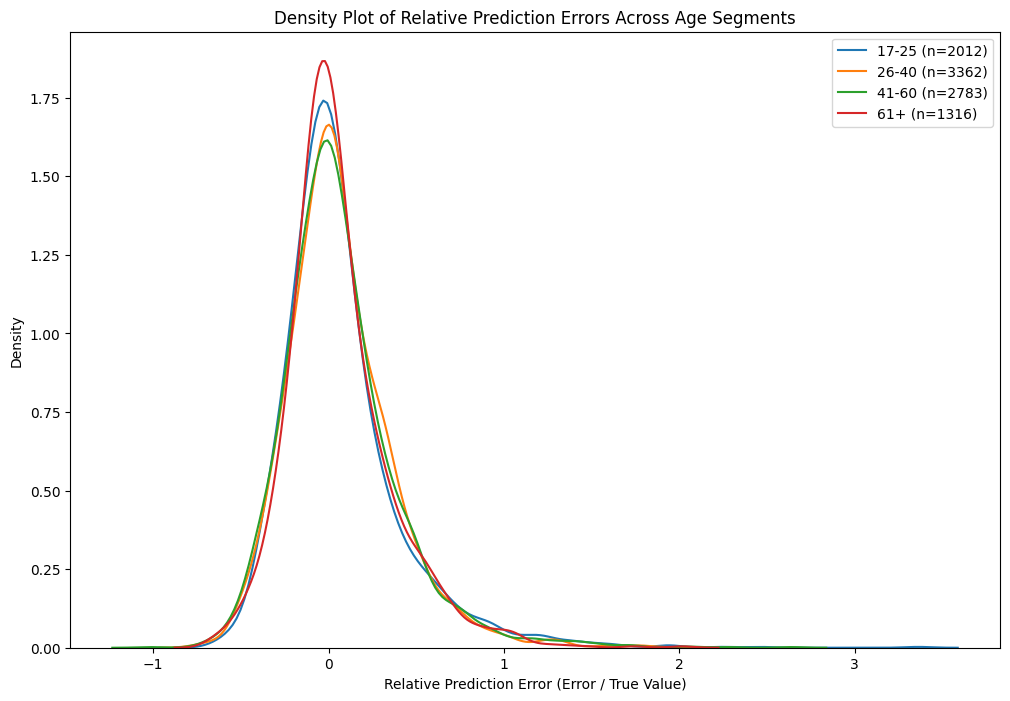

In [3]:
# Plotting the density curve of relative prediction errors for all segments
plt.figure(figsize=(12, 8))

# Calculate and plot the relative errors (error / true value)
for label, errors in prediction_errors.items():
    true_values = y_test.loc[errors.index]  # Get the corresponding true values
    relative_errors = errors / true_values  # Calculate relative errors
    sns.kdeplot(relative_errors, label=segment_labels.pop(0))

plt.title('Density Plot of Relative Prediction Errors Across Age Segments')
plt.xlabel('Relative Prediction Error (Error / True Value)')
plt.ylabel('Density')
plt.legend()
plt.show()


In [4]:
# Initialize lists to store all combined predictions and true values
all_y_test = []
all_y_pred = []

# Function to train and evaluate model for each segment
def train_evaluate_segment(segment_name, train_data, test_data, y_train_seg, y_test_seg):
    if len(train_data) < 2 or len(test_data) < 2:
        print(f"Segment too small, skipping this segment.")
        return None

    model = XGBRegressor(random_state=2024)
    
    model.fit(train_data, y_train_seg)
    y_pred = model.predict(test_data)
    
    # Combine predictions and true values, ensuring alignment
    all_y_test.extend(y_test_seg.tolist())
    all_y_pred.extend(y_pred.tolist())

    print(f'Segment: {segment_name} evaluated')

# Train and evaluate each segment
for segment_name in train_segments.keys():
    train_evaluate_segment(segment_name,
                           train_segments[segment_name][0],  # Train data
                           test_segments[segment_name][0],   # Test data
                           train_segments[segment_name][1],  # Train labels
                           test_segments[segment_name][1])   # Test labels

# Convert combined lists to numpy arrays for evaluation
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)

# Check if predictions and true values are still aligned (optional, for debugging)
assert len(all_y_test) == len(all_y_pred), "Mismatch between true values and predictions length."

# Evaluate the model on the combined data
mse = mean_squared_error(all_y_test, all_y_pred)
mae = mean_absolute_error(all_y_test, all_y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((all_y_test - all_y_pred) / all_y_test)) * 100
rmspe = np.sqrt(np.mean(np.square((all_y_test - all_y_pred) / all_y_test))) * 100
r2 = r2_score(all_y_test, all_y_pred)

print(f'\nOverall Metrics for Combined Test Set:')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')
print(f'Root Mean Squared Percentage Error: {rmspe:.2f}%')
print(f'R-squared: {r2:.2f}')

# Function to calculate percentage within tolerance
def calculate_within_tolerance(y_true, y_pred, tolerance):
    within_tolerance = abs(y_true - y_pred) / y_true <= tolerance
    percentage_within_tolerance = within_tolerance.mean() * 100
    return percentage_within_tolerance

# Apply the function to the combined data
within_10_percent = calculate_within_tolerance(all_y_test, all_y_pred, 0.10)
within_50_percent = calculate_within_tolerance(all_y_test, all_y_pred, 0.50)
within_100_percent = calculate_within_tolerance(all_y_test, all_y_pred, 1.00)

print(f'Percentage within 10%: {within_10_percent:.2f}%')
print(f'Percentage within 50%: {within_50_percent:.2f}%')
print(f'Percentage within 100%: {within_100_percent:.2f}%')


Segment: 17-25 evaluated
Segment: 26-40 evaluated
Segment: 41-60 evaluated
Segment: 61+ evaluated

Overall Metrics for Combined Test Set:
Mean Squared Error: 94959.65291534118
Mean Absolute Error: 201.1186181317747
Root Mean Squared Error: 308.1552415834285
Mean Absolute Percentage Error: 22.67%
Root Mean Squared Percentage Error: 32.67%
R-squared: 0.78
Percentage within 10%: 34.23%
Percentage within 50%: 90.55%
Percentage within 100%: 98.47%


In [5]:
# try normalised premium

In [6]:
##################

Mean Squared Error: 99620.07689685817
Percentage within 10%: 29.59%
Percentage within 50%: 89.84%
Percentage within 100%: 98.36%


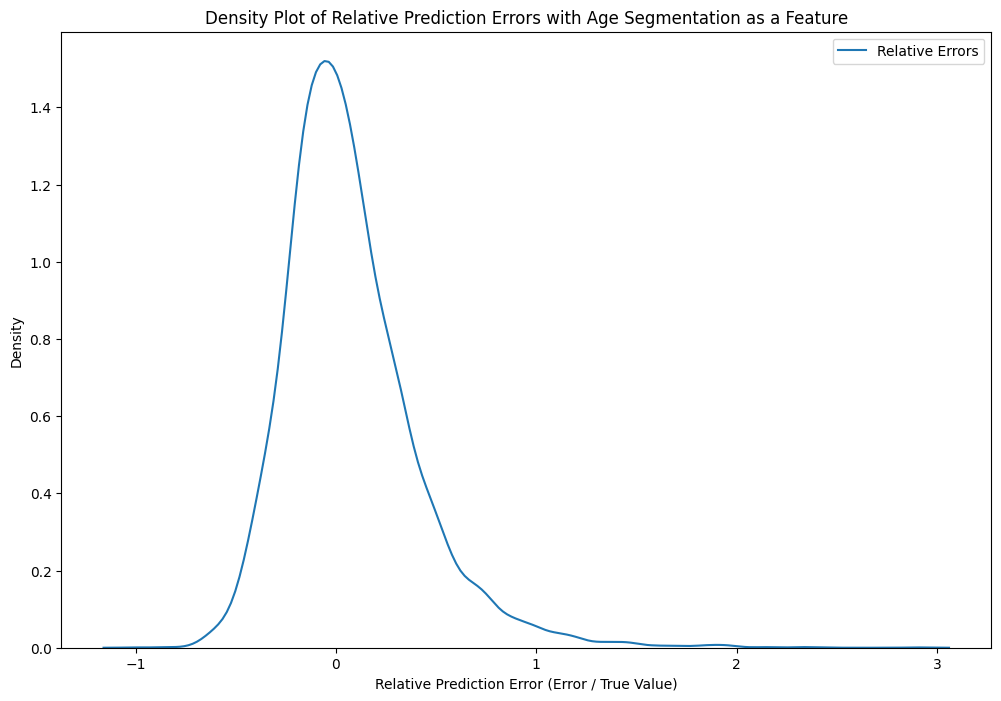

In [7]:

# Function to assign segment based on standardized age
def assign_age_segment(df, age_column, thresholds):
    conditions = [
        (df[age_column] >= thresholds['17-25'][0]) & (df[age_column] <= thresholds['17-25'][1]),
        (df[age_column] > thresholds['26-40'][0]) & (df[age_column] <= thresholds['26-40'][1]),
        (df[age_column] > thresholds['41-60'][0]) & (df[age_column] <= thresholds['41-60'][1]),
        (df[age_column] > thresholds['61+'][0])
    ]
    choices = [1, 2, 3, 4]
    df['age_segment'] = np.select(conditions, choices, default=0)
    return df

# Assign segments to both train and test sets
X_train = assign_age_segment(X_train.copy(), 'DRIVER1_AGE', age_thresholds_standardized)
X_test = assign_age_segment(X_test.copy(), 'DRIVER1_AGE', age_thresholds_standardized)

# Train the model using the entire dataset with the segment feature
model = XGBRegressor(random_state=seed_num)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
within_10_percent = calculate_within_tolerance(y_test, y_pred, 0.10)
within_50_percent = calculate_within_tolerance(y_test, y_pred, 0.50)
within_100_percent = calculate_within_tolerance(y_test, y_pred, 1.00)

print(f'Mean Squared Error: {mse}')
print(f'Percentage within 10%: {within_10_percent:.2f}%')
print(f'Percentage within 50%: {within_50_percent:.2f}%')
print(f'Percentage within 100%: {within_100_percent:.2f}%')

# Calculate relative errors for plotting
relative_errors = (y_pred - y_test) / y_test

# Plotting the density curve of relative prediction errors
plt.figure(figsize=(12, 8))
sns.kdeplot(relative_errors)
plt.title(f'Density Plot of Relative Prediction Errors with Age Segmentation as a Feature')
plt.xlabel('Relative Prediction Error (Error / True Value)')
plt.ylabel('Density')
plt.legend(['Relative Errors'])
plt.show()

# Function to calculate percentage within tolerance
def calculate_within_tolerance(y_true, y_pred, tolerance):
    within_tolerance = abs(y_true - y_pred) / y_true <= tolerance
    percentage_within_tolerance = within_tolerance.mean() * 100
    return percentage_within_tolerance